# Introduction to Bayesian Last Layer

Required Tensorflow 2.x to run (where Keras is part of Tensorflow and not a stand-alone package)

In [21]:
import numpy as np
import scipy
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import tensorflow as tf
from tensorflow import keras
from sklearn import datasets

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel
from sklearn import preprocessing

import tikzplotlib

In [2]:
import matplotlib as mpl
from cycler import cycler
import matplotlib.ticker as plticker

mpl.rcParams.update({
    'lines.linewidth':2,
    'font.size': 18,
    'figure.figsize': (9, 6),
    'axes.grid': True,
    'lines.markersize': 10,
    'text.usetex': True,
    'axes.unicode_minus': False,
    'ps.fonttype': 42,
    'pdf.fonttype': 42
})

color = mpl.rcParams['axes.prop_cycle'].by_key()['color']

# Utility functions

In [3]:
def get_keras_model(architecture, activation='relu'):
    """Function to obtain a Keras model
    
    Model is defined by the parameter ``architecture`` which must be a list. 
    
    Example:
        
        architecture = [1, 5, 5, 1]
        
    Returns a NN with one input, two hidden layers (each with 5 neurons) and one output.
    
    All hidden layer (except for the output layer) have the same activation function.
    """
    inputs = keras.Input(shape=architecture[0], name='input')
    outputs = [inputs]
    
    for n_l in range(1, len(architecture)-1):
        outputs.append(keras.layers.Dense(architecture[n_l], 
                                 activation=activation,
                                 name='hidden_{}'.format(n_l))(outputs[n_l-1]))
        
    outputs.append(keras.layers.Dense(architecture[-1], 
                                      name='output')(outputs[-1]))
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs[-1]) 
    return model, outputs

In [4]:
def figure_1d_data(ax, true=None, train=None, test=None, legend=True):
    """
    Create a figure for 1-D Data give true data, train data and test data. 
    (true,train,test) data must be tuples with (x,y) arrays. 
    
    Returns the figure and axis with the plotted data (for potential post-processing)
    """
    
    if true is not None:
        ax.plot(true[0].flatten(),true[1].flatten(),label='true')
    
    if train is not None:
        ax.set_prop_cycle(None)
        ax.plot(train[0].flatten(),train[1].flatten(),'x', label='measured')
    
    if test is not None:
        ax.plot(test[0].flatten(),test[1].flatten(), label='predicted') 
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    if legend == True:
        ax.legend()

In [5]:
def get_data(m, x_range=[0,1], dtype=0, x_type='random', sigma=0):
    """ Data generating function. Choose the following parameters:
    
    m       :     number of samples
    x_range :     well, x range
    dtype   :     Defines the function from which data is sampled.
    x_type  :     x values can either be sampled ``random`` within the range or```linear``
    sigma   :     Noise level
    
    Returns the tuple (x,y)
    """
    if x_type == 'random':
        x = np.sort(np.random.rand(m)).reshape(-1,1)
        x *= x_range[1]-x_range[0]
        x += x_range[0]
    elif x_type == 'linear':
        x = np.linspace(x_range[0], x_range[1], m)
        
    if dtype == 0:
        y = 5*x + 0.6*np.sin(5*np.pi*x)
    elif dtype == 1:
        y = x**2*np.sin(4*x*np.pi)
    elif dtype == 2:
        y = np.round(4*x)%2
    elif dtype == 3:
        y = x
    elif dtype == 4:
        y = 0.1*x**3 
    elif dtype == 5:
        y = (3*x + 2)
    elif dtype == 6:
        y = (3*x + 2)*(x<10)
        y += (-2*x+52)*(x>=10)
    else:
        raise Exception('dtype {} is not supported'.format(dtype))
    
        
    w = np.random.randn(*y.shape)*sigma
    y += w
        
    return x,y

# Examples

## Example 01

2021-11-12 15:38:32.039594: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-12 15:38:32.040088: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


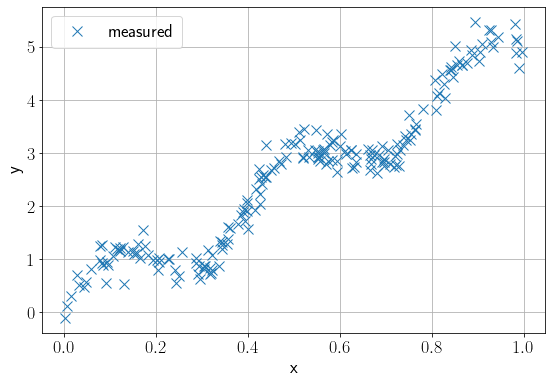

In [6]:
np.random.seed(123)
tf.random.set_seed(123)

architecture = [1, 20, 20, 1]

model, outputs = get_keras_model(architecture, 'tanh')

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.MSE,
)

activation_model = tf.keras.Model(inputs=outputs[0],outputs=outputs[-2])

data_type = 0

sig_e_data = 0.2
train = get_data(200,[0,1],data_type, sigma=sig_e_data)

fig, ax = plt.subplots()
figure_1d_data(ax, train=train)

Train neural network:

In [7]:
history = model.fit(
    train[0], 
    train[1],
    epochs=1000,
)

2021-11-12 15:38:38.015289: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/1000
7/7 [==============================] - 0s 968us/step - loss: 8.2980
Epoch 2/1000
7/7 [==============================] - 0s 670us/step - loss: 2.2343
Epoch 3/1000
7/7 [==============================] - 0s 601us/step - loss: 1.3187
Epoch 4/1000
7/7 [==============================] - 0s 631us/step - loss: 0.9712
Epoch 5/1000
7/7 [==============================] - 0s 682us/step - loss: 0.7154
Epoch 6/1000
7/7 [==============================] - 0s 627us/step - loss: 0.5710
Epoch 7/1000
7/7 [==============================] - 0s 653us/step - loss: 0.4064
Epoch 8/1000
7/7 [==============================] - 0s 638us/step - loss: 0.3021
Epoch 9/1000
7/7 [==============================] - 0s 635us/step - loss: 0.3267
Epoch 10/1000
7/7 [==============================] - 0s 657us/step - loss: 0.3000
Epoch 11/1000
7/7 [==============================] - 0s 624us/step - loss: 0.2882
Epoch 12/1000
7/7 [==============================] - 0s 623us/step - loss: 0.2771
Epoch 13/1000
7/7 [======

7/7 [==============================] - 0s 730us/step - loss: 0.2098
Epoch 102/1000
7/7 [==============================] - 0s 729us/step - loss: 0.1997
Epoch 103/1000
7/7 [==============================] - 0s 599us/step - loss: 0.1963
Epoch 104/1000
7/7 [==============================] - 0s 581us/step - loss: 0.2130
Epoch 105/1000
7/7 [==============================] - 0s 604us/step - loss: 0.2082
Epoch 106/1000
7/7 [==============================] - 0s 607us/step - loss: 0.2054
Epoch 107/1000
7/7 [==============================] - 0s 611us/step - loss: 0.2124
Epoch 108/1000
7/7 [==============================] - 0s 595us/step - loss: 0.1959
Epoch 109/1000
7/7 [==============================] - 0s 661us/step - loss: 0.1908
Epoch 110/1000
7/7 [==============================] - 0s 722us/step - loss: 0.1843
Epoch 111/1000
7/7 [==============================] - 0s 585us/step - loss: 0.1907
Epoch 112/1000
7/7 [==============================] - 0s 614us/step - loss: 0.1927
Epoch 113/1000
7/7 

7/7 [==============================] - 0s 633us/step - loss: 0.0505
Epoch 298/1000
7/7 [==============================] - 0s 670us/step - loss: 0.0590
Epoch 299/1000
7/7 [==============================] - 0s 641us/step - loss: 0.0568
Epoch 300/1000
7/7 [==============================] - 0s 681us/step - loss: 0.0572
Epoch 301/1000
7/7 [==============================] - 0s 599us/step - loss: 0.0546
Epoch 302/1000
7/7 [==============================] - 0s 591us/step - loss: 0.0531
Epoch 303/1000
7/7 [==============================] - 0s 609us/step - loss: 0.0597
Epoch 304/1000
7/7 [==============================] - 0s 684us/step - loss: 0.0597
Epoch 305/1000
7/7 [==============================] - 0s 596us/step - loss: 0.0540
Epoch 306/1000
7/7 [==============================] - 0s 625us/step - loss: 0.0683
Epoch 307/1000
7/7 [==============================] - 0s 650us/step - loss: 0.0789
Epoch 308/1000
7/7 [==============================] - 0s 645us/step - loss: 0.0584
Epoch 309/1000
7/7 

7/7 [==============================] - 0s 605us/step - loss: 0.0449
Epoch 494/1000
7/7 [==============================] - 0s 650us/step - loss: 0.0507
Epoch 495/1000
7/7 [==============================] - 0s 675us/step - loss: 0.0530
Epoch 496/1000
7/7 [==============================] - 0s 628us/step - loss: 0.0540
Epoch 497/1000
7/7 [==============================] - 0s 639us/step - loss: 0.0492
Epoch 498/1000
7/7 [==============================] - 0s 645us/step - loss: 0.0465
Epoch 499/1000
7/7 [==============================] - 0s 595us/step - loss: 0.0443
Epoch 500/1000
7/7 [==============================] - 0s 660us/step - loss: 0.0485
Epoch 501/1000
7/7 [==============================] - 0s 697us/step - loss: 0.0403
Epoch 502/1000
7/7 [==============================] - 0s 619us/step - loss: 0.0426
Epoch 503/1000
7/7 [==============================] - 0s 616us/step - loss: 0.0440
Epoch 504/1000
7/7 [==============================] - 0s 657us/step - loss: 0.0474
Epoch 505/1000
7/7 

7/7 [==============================] - 0s 642us/step - loss: 0.0443
Epoch 690/1000
7/7 [==============================] - 0s 619us/step - loss: 0.0445
Epoch 691/1000
7/7 [==============================] - 0s 619us/step - loss: 0.0338
Epoch 692/1000
7/7 [==============================] - 0s 642us/step - loss: 0.0372
Epoch 693/1000
7/7 [==============================] - 0s 623us/step - loss: 0.0375
Epoch 694/1000
7/7 [==============================] - 0s 612us/step - loss: 0.0379
Epoch 695/1000
7/7 [==============================] - 0s 602us/step - loss: 0.0416
Epoch 696/1000
7/7 [==============================] - 0s 628us/step - loss: 0.0378
Epoch 697/1000
7/7 [==============================] - 0s 637us/step - loss: 0.0385
Epoch 698/1000
7/7 [==============================] - 0s 622us/step - loss: 0.0549
Epoch 699/1000
7/7 [==============================] - 0s 686us/step - loss: 0.0374
Epoch 700/1000
7/7 [==============================] - 0s 614us/step - loss: 0.0377
Epoch 701/1000
7/7 

7/7 [==============================] - 0s 617us/step - loss: 0.0399
Epoch 886/1000
7/7 [==============================] - 0s 630us/step - loss: 0.0409
Epoch 887/1000
7/7 [==============================] - 0s 663us/step - loss: 0.0388
Epoch 888/1000
7/7 [==============================] - 0s 744us/step - loss: 0.0430
Epoch 889/1000
7/7 [==============================] - 0s 649us/step - loss: 0.0488
Epoch 890/1000
7/7 [==============================] - 0s 632us/step - loss: 0.0398
Epoch 891/1000
7/7 [==============================] - 0s 582us/step - loss: 0.0436
Epoch 892/1000
7/7 [==============================] - 0s 589us/step - loss: 0.0342
Epoch 893/1000
7/7 [==============================] - 0s 595us/step - loss: 0.0361
Epoch 894/1000
7/7 [==============================] - 0s 613us/step - loss: 0.0370
Epoch 895/1000
7/7 [==============================] - 0s 612us/step - loss: 0.0396
Epoch 896/1000
7/7 [==============================] - 0s 591us/step - loss: 0.0373
Epoch 897/1000
7/7 

Prediction and uncertainty information from BLL:

In [8]:
sig_w = 1e1
sig_e = sig_e_data

Sigma_E = np.eye(train[1].shape[0])*1/sig_e**2          
Sigma_W = np.eye(architecture[-2])*1/sig_w**2


true = get_data(300, [-2,3.], dtype=data_type, x_type='linear')
x_test = true[0]
y_hat_nn = model.predict(x_test).flatten()
a_train = activation_model.predict(train[0])
a_hat = activation_model.predict(x_test)

cov = a_hat@np.linalg.inv(a_train.T@Sigma_E@a_train+Sigma_W)@a_hat.T
std_nn = np.sqrt(np.diag(cov))

In [9]:
gpr = GaussianProcessRegressor(kernel=RBF(length_scale=0.2),normalize_y=True, alpha=1/(sig_w**2)).fit(*train)

y_hat_gp, std_gp = gpr.predict(x_test.reshape(-1,1), return_std=True)
y_hat_gp = y_hat_gp.flatten()

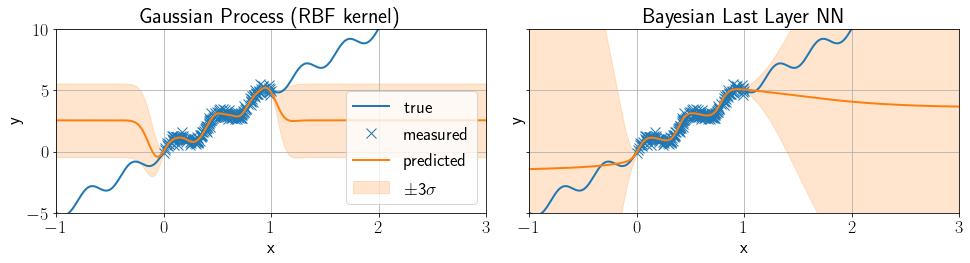

In [10]:
n_sig = 3

fig, ax = plt.subplots(1,2, sharex=True, sharey = True, figsize=(14,4))

# GP
figure_1d_data(ax[0], true=true, train=train, test=(x_test,y_hat_gp))
ax[0].fill_between(x_test.flatten(), y_hat_gp-n_sig*std_gp, y_hat_gp+n_sig*std_gp, alpha=0.2, label=f'$\pm${n_sig}$\sigma$', color=color[1])
ax[0].legend()


# NN
figure_1d_data(ax[1], true=true, train=train, test=(x_test,y_hat_nn), legend=False)
ax[1].fill_between(x_test.flatten(), y_hat_nn-n_sig*std_nn, y_hat_nn+n_sig*std_nn, alpha=0.2, label=f'$\pm${n_sig}$\sigma$', color=color[1])

ax[0].set_title('Gaussian Process (RBF kernel)')
ax[1].set_title('Bayesian Last Layer NN')

ax[1].set_ylim(-5,10)
ax[1].set_xlim(-1,3)

fig.tight_layout()

fig.savefig('./figures/BLL_GP_1D_dtype_0.pdf',format='pdf',pad_inches=0)

## Example 02

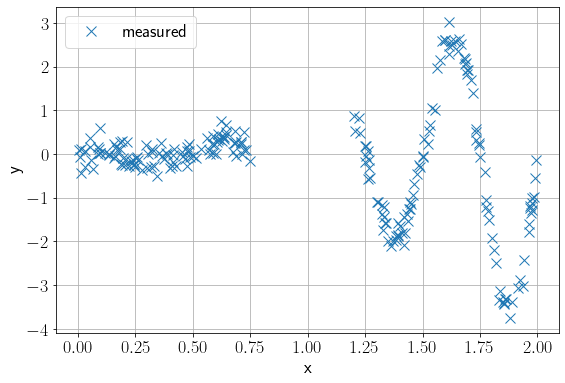

In [11]:
np.random.seed(123)
tf.random.set_seed(123)

architecture = [1, 20, 20, 1]

model, outputs = get_keras_model(architecture, 'tanh')

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.MSE,
)

activation_model = tf.keras.Model(inputs=outputs[0],outputs=outputs[-2])

data_type = 1

sig_e_data = 0.2
train = get_data(300,[0,2],data_type, sigma=sig_e_data)

# Make gap in data
indx = (train[0]>0.75)&(train[0]<1.2)
train = (train[0][~indx].reshape(-1,1), train[1][~indx].reshape(-1,1))

fig, ax = plt.subplots()
figure_1d_data(ax, train=train)

In [12]:
history = model.fit(
    train[0], 
    train[1],
    batch_size=50,
    epochs=1000,
)

Epoch 1/1000
5/5 [==============================] - 0s 1ms/step - loss: 1.5228
Epoch 2/1000
5/5 [==============================] - 0s 1ms/step - loss: 1.6030
Epoch 3/1000
5/5 [==============================] - 0s 844us/step - loss: 1.5965
Epoch 4/1000
5/5 [==============================] - 0s 801us/step - loss: 1.7046
Epoch 5/1000
5/5 [==============================] - 0s 742us/step - loss: 1.5439
Epoch 6/1000
5/5 [==============================] - 0s 737us/step - loss: 1.5244
Epoch 7/1000
5/5 [==============================] - 0s 740us/step - loss: 1.6168
Epoch 8/1000
5/5 [==============================] - 0s 755us/step - loss: 1.7065
Epoch 9/1000
5/5 [==============================] - 0s 836us/step - loss: 1.5125
Epoch 10/1000
5/5 [==============================] - 0s 719us/step - loss: 1.5607
Epoch 11/1000
5/5 [==============================] - 0s 678us/step - loss: 1.5576
Epoch 12/1000
5/5 [==============================] - 0s 669us/step - loss: 1.4936
Epoch 13/1000
5/5 [==========

5/5 [==============================] - 0s 840us/step - loss: 1.2220
Epoch 200/1000
5/5 [==============================] - 0s 739us/step - loss: 1.0282
Epoch 201/1000
5/5 [==============================] - 0s 686us/step - loss: 1.1332
Epoch 202/1000
5/5 [==============================] - 0s 736us/step - loss: 1.0780
Epoch 203/1000
5/5 [==============================] - 0s 685us/step - loss: 0.9915
Epoch 204/1000
5/5 [==============================] - 0s 644us/step - loss: 1.0696
Epoch 205/1000
5/5 [==============================] - 0s 682us/step - loss: 0.9789
Epoch 206/1000
5/5 [==============================] - 0s 668us/step - loss: 0.9859
Epoch 207/1000
5/5 [==============================] - 0s 710us/step - loss: 0.8768
Epoch 208/1000
5/5 [==============================] - 0s 625us/step - loss: 0.9398
Epoch 209/1000
5/5 [==============================] - 0s 645us/step - loss: 0.8057
Epoch 210/1000
5/5 [==============================] - 0s 795us/step - loss: 0.7289
Epoch 211/1000
5/5 

5/5 [==============================] - 0s 789us/step - loss: 0.0579
Epoch 396/1000
5/5 [==============================] - 0s 755us/step - loss: 0.0572
Epoch 397/1000
5/5 [==============================] - 0s 638us/step - loss: 0.0717
Epoch 398/1000
5/5 [==============================] - 0s 695us/step - loss: 0.0578
Epoch 399/1000
5/5 [==============================] - 0s 898us/step - loss: 0.0720
Epoch 400/1000
5/5 [==============================] - 0s 713us/step - loss: 0.0741
Epoch 401/1000
5/5 [==============================] - 0s 717us/step - loss: 0.0775
Epoch 402/1000
5/5 [==============================] - 0s 760us/step - loss: 0.1078
Epoch 403/1000
5/5 [==============================] - 0s 742us/step - loss: 0.0956
Epoch 404/1000
5/5 [==============================] - 0s 784us/step - loss: 0.0788
Epoch 405/1000
5/5 [==============================] - 0s 732us/step - loss: 0.0663
Epoch 406/1000
5/5 [==============================] - 0s 693us/step - loss: 0.0627
Epoch 407/1000
5/5 

5/5 [==============================] - 0s 672us/step - loss: 0.0539
Epoch 592/1000
5/5 [==============================] - 0s 711us/step - loss: 0.0441
Epoch 593/1000
5/5 [==============================] - 0s 699us/step - loss: 0.0385
Epoch 594/1000
5/5 [==============================] - 0s 772us/step - loss: 0.0467
Epoch 595/1000
5/5 [==============================] - 0s 746us/step - loss: 0.0461
Epoch 596/1000
5/5 [==============================] - 0s 769us/step - loss: 0.0505
Epoch 597/1000
5/5 [==============================] - 0s 690us/step - loss: 0.0488
Epoch 598/1000
5/5 [==============================] - 0s 791us/step - loss: 0.0533
Epoch 599/1000
5/5 [==============================] - 0s 684us/step - loss: 0.0657
Epoch 600/1000
5/5 [==============================] - 0s 654us/step - loss: 0.0475
Epoch 601/1000
5/5 [==============================] - 0s 675us/step - loss: 0.0496
Epoch 602/1000
5/5 [==============================] - 0s 682us/step - loss: 0.0523
Epoch 603/1000
5/5 

5/5 [==============================] - 0s 806us/step - loss: 0.0469
Epoch 788/1000
5/5 [==============================] - 0s 731us/step - loss: 0.0689
Epoch 789/1000
5/5 [==============================] - 0s 683us/step - loss: 0.0610
Epoch 790/1000
5/5 [==============================] - 0s 754us/step - loss: 0.0492
Epoch 791/1000
5/5 [==============================] - 0s 784us/step - loss: 0.0508
Epoch 792/1000
5/5 [==============================] - 0s 684us/step - loss: 0.0534
Epoch 793/1000
5/5 [==============================] - 0s 675us/step - loss: 0.0808
Epoch 794/1000
5/5 [==============================] - 0s 710us/step - loss: 0.0535
Epoch 795/1000
5/5 [==============================] - 0s 667us/step - loss: 0.0476
Epoch 796/1000
5/5 [==============================] - 0s 648us/step - loss: 0.0514
Epoch 797/1000
5/5 [==============================] - 0s 709us/step - loss: 0.0451
Epoch 798/1000
5/5 [==============================] - 0s 697us/step - loss: 0.0477
Epoch 799/1000
5/5 

5/5 [==============================] - 0s 749us/step - loss: 0.0632
Epoch 984/1000
5/5 [==============================] - 0s 682us/step - loss: 0.0557
Epoch 985/1000
5/5 [==============================] - 0s 670us/step - loss: 0.0723
Epoch 986/1000
5/5 [==============================] - 0s 668us/step - loss: 0.0498
Epoch 987/1000
5/5 [==============================] - 0s 708us/step - loss: 0.0459
Epoch 988/1000
5/5 [==============================] - 0s 666us/step - loss: 0.0562
Epoch 989/1000
5/5 [==============================] - 0s 705us/step - loss: 0.0502
Epoch 990/1000
5/5 [==============================] - 0s 694us/step - loss: 0.0425
Epoch 991/1000
5/5 [==============================] - 0s 747us/step - loss: 0.0603
Epoch 992/1000
5/5 [==============================] - 0s 719us/step - loss: 0.0568
Epoch 993/1000
5/5 [==============================] - 0s 655us/step - loss: 0.0522
Epoch 994/1000
5/5 [==============================] - 0s 664us/step - loss: 0.0518
Epoch 995/1000
5/5 

In [16]:
sig_w_gp = 1e0
sig_w_nn = 1e3
sig_e = sig_e_data

Sigma_E = np.eye(train[1].shape[0])*1/sig_e**2          
Sigma_W = np.eye(architecture[-2])*1/sig_w_nn**2


true = get_data(300, [-2,3.], dtype=data_type, x_type='linear')
x_test = true[0]
y_hat_nn = model.predict(x_test).flatten()
a_train = activation_model.predict(train[0])
a_hat = activation_model.predict(x_test)

cov = a_hat@np.linalg.inv(a_train.T@Sigma_E@a_train+Sigma_W)@a_hat.T
std_nn = np.sqrt(np.diag(cov))

In [17]:
gpr = GaussianProcessRegressor(kernel=RBF(length_scale=0.2),normalize_y=True, alpha=1/(sig_w_gp**2)).fit(*train)

y_hat_gp, std_gp = gpr.predict(x_test.reshape(-1,1), return_std=True)
y_hat_gp = y_hat_gp.flatten()

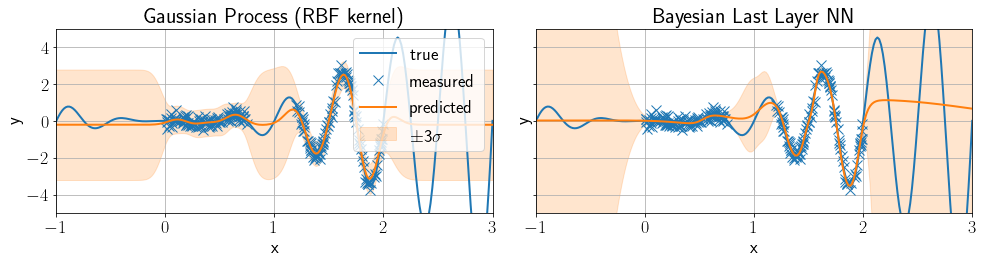

In [24]:
n_sig = 3

fig, ax = plt.subplots(1,2, sharex=True, sharey = True, figsize=(14,4))

# GP
figure_1d_data(ax[0], true=true, train=train, test=(x_test,y_hat_gp),legend=True)
ax[0].fill_between(x_test.flatten(), y_hat_gp-n_sig*std_gp, y_hat_gp+n_sig*std_gp, alpha=0.2, label=f'$\pm${n_sig}$\sigma$', color=color[1])
ax[0].legend()

# NN
figure_1d_data(ax[1], true=true, train=train, test=(x_test,y_hat_nn), legend=False)
ax[1].fill_between(x_test.flatten(), y_hat_nn-n_sig*std_nn, y_hat_nn+n_sig*std_nn, alpha=0.2, label=f'$\pm${n_sig}$\sigma$', color=color[1])

ax[1].set_xlim(-1,3)
ax[1].set_ylim(-5,5)
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax[1].xaxis.set_major_locator(loc)

ax[0].set_title('Gaussian Process (RBF kernel)')
ax[1].set_title('Bayesian Last Layer NN')

fig.tight_layout()

fig.savefig('./figures/BLL_GP_1D_dtype_1.pdf',format='pdf',pad_inches=0)

## Example 3:

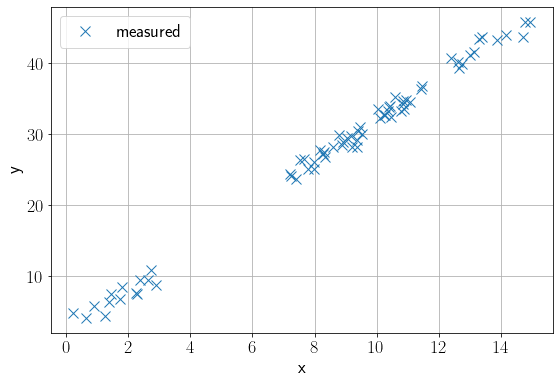

In [25]:
np.random.seed(123)
tf.random.set_seed(123)

architecture = [1, 20, 20, 1]

model, outputs = get_keras_model(architecture, 'tanh')

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MSE,
)

activation_model = tf.keras.Model(inputs=outputs[0],outputs=outputs[-2])

data_type = 5

sig_e_data = 1
train = get_data(100,[0,15], data_type, sigma = sig_e_data)

indx = (train[0]>3)&(train[0]<7)
train = (train[0][~indx].reshape(-1,1), train[1][~indx].reshape(-1,1))

fig, ax = plt.subplots()
figure_1d_data(ax, train=train)

In [26]:
history = model.fit(
    train[0], 
    train[1],
    epochs=2000,
    batch_size = 20
)

Epoch 1/2000
4/4 [==============================] - 0s 877us/step - loss: 922.5104
Epoch 2/2000
4/4 [==============================] - 0s 836us/step - loss: 907.6014
Epoch 3/2000
4/4 [==============================] - 0s 770us/step - loss: 938.1042
Epoch 4/2000
4/4 [==============================] - 0s 685us/step - loss: 915.4331
Epoch 5/2000
4/4 [==============================] - 0s 709us/step - loss: 910.4037
Epoch 6/2000
4/4 [==============================] - 0s 732us/step - loss: 883.2726
Epoch 7/2000
4/4 [==============================] - 0s 777us/step - loss: 857.5722
Epoch 8/2000
4/4 [==============================] - 0s 808us/step - loss: 857.0490
Epoch 9/2000
4/4 [==============================] - 0s 682us/step - loss: 871.0283
Epoch 10/2000
4/4 [==============================] - 0s 772us/step - loss: 801.1580
Epoch 11/2000
4/4 [==============================] - 0s 791us/step - loss: 792.5326
Epoch 12/2000
4/4 [==============================] - 0s 734us/step - loss: 807.7730
E

4/4 [==============================] - 0s 836us/step - loss: 225.6961
Epoch 195/2000
4/4 [==============================] - 0s 819us/step - loss: 244.2366
Epoch 196/2000
4/4 [==============================] - 0s 759us/step - loss: 200.6322
Epoch 197/2000
4/4 [==============================] - 0s 789us/step - loss: 225.9776
Epoch 198/2000
4/4 [==============================] - 0s 756us/step - loss: 218.8753
Epoch 199/2000
4/4 [==============================] - 0s 827us/step - loss: 245.5447
Epoch 200/2000
4/4 [==============================] - 0s 774us/step - loss: 224.4812
Epoch 201/2000
4/4 [==============================] - 0s 819us/step - loss: 206.0271
Epoch 202/2000
4/4 [==============================] - 0s 786us/step - loss: 205.4905
Epoch 203/2000
4/4 [==============================] - 0s 754us/step - loss: 195.5763
Epoch 204/2000
4/4 [==============================] - 0s 854us/step - loss: 193.5801
Epoch 205/2000
4/4 [==============================] - 0s 857us/step - loss: 174.

4/4 [==============================] - 0s 832us/step - loss: 52.6683
Epoch 388/2000
4/4 [==============================] - 0s 917us/step - loss: 57.1628
Epoch 389/2000
4/4 [==============================] - 0s 923us/step - loss: 57.9493
Epoch 390/2000
4/4 [==============================] - 0s 822us/step - loss: 64.3039
Epoch 391/2000
4/4 [==============================] - 0s 859us/step - loss: 59.0040
Epoch 392/2000
4/4 [==============================] - 0s 738us/step - loss: 57.1570
Epoch 393/2000
4/4 [==============================] - 0s 735us/step - loss: 50.8595
Epoch 394/2000
4/4 [==============================] - 0s 792us/step - loss: 63.8925
Epoch 395/2000
4/4 [==============================] - 0s 808us/step - loss: 53.3395
Epoch 396/2000
4/4 [==============================] - 0s 746us/step - loss: 55.1432
Epoch 397/2000
4/4 [==============================] - 0s 757us/step - loss: 52.0310
Epoch 398/2000
4/4 [==============================] - 0s 892us/step - loss: 57.6166
Epoch 3

4/4 [==============================] - 0s 834us/step - loss: 23.6808
Epoch 582/2000
4/4 [==============================] - 0s 787us/step - loss: 23.2430
Epoch 583/2000
4/4 [==============================] - 0s 879us/step - loss: 22.9332
Epoch 584/2000
4/4 [==============================] - 0s 825us/step - loss: 21.0131
Epoch 585/2000
4/4 [==============================] - 0s 773us/step - loss: 23.7420
Epoch 586/2000
4/4 [==============================] - 0s 859us/step - loss: 16.1894
Epoch 587/2000
4/4 [==============================] - 0s 825us/step - loss: 21.0287
Epoch 588/2000
4/4 [==============================] - 0s 881us/step - loss: 19.7542
Epoch 589/2000
4/4 [==============================] - 0s 641us/step - loss: 20.1322
Epoch 590/2000
4/4 [==============================] - 0s 714us/step - loss: 18.7526
Epoch 591/2000
4/4 [==============================] - 0s 801us/step - loss: 19.8835
Epoch 592/2000
4/4 [==============================] - 0s 776us/step - loss: 18.8167
Epoch 5

4/4 [==============================] - 0s 777us/step - loss: 8.2511
Epoch 777/2000
4/4 [==============================] - 0s 815us/step - loss: 7.1226
Epoch 778/2000
4/4 [==============================] - 0s 871us/step - loss: 8.0465
Epoch 779/2000
4/4 [==============================] - 0s 832us/step - loss: 6.7138
Epoch 780/2000
4/4 [==============================] - 0s 730us/step - loss: 8.0815
Epoch 781/2000
4/4 [==============================] - 0s 718us/step - loss: 8.5597
Epoch 782/2000
4/4 [==============================] - 0s 806us/step - loss: 6.0833
Epoch 783/2000
4/4 [==============================] - 0s 870us/step - loss: 7.2470
Epoch 784/2000
4/4 [==============================] - 0s 848us/step - loss: 8.1091
Epoch 785/2000
4/4 [==============================] - 0s 737us/step - loss: 7.3652
Epoch 786/2000
4/4 [==============================] - 0s 979us/step - loss: 9.1978
Epoch 787/2000
4/4 [==============================] - 0s 748us/step - loss: 9.4231
Epoch 788/2000
4/4 

Epoch 875/2000
4/4 [==============================] - 0s 814us/step - loss: 4.8636
Epoch 876/2000
4/4 [==============================] - 0s 828us/step - loss: 4.1168
Epoch 877/2000
4/4 [==============================] - 0s 907us/step - loss: 4.8037
Epoch 878/2000
4/4 [==============================] - 0s 903us/step - loss: 5.1323
Epoch 879/2000
4/4 [==============================] - 0s 852us/step - loss: 5.0420
Epoch 880/2000
4/4 [==============================] - 0s 774us/step - loss: 4.5006
Epoch 881/2000
4/4 [==============================] - 0s 736us/step - loss: 5.0306
Epoch 882/2000
4/4 [==============================] - 0s 877us/step - loss: 4.4838
Epoch 883/2000
4/4 [==============================] - 0s 734us/step - loss: 4.8062
Epoch 884/2000
4/4 [==============================] - 0s 839us/step - loss: 3.8572
Epoch 885/2000
4/4 [==============================] - 0s 822us/step - loss: 5.6197
Epoch 886/2000
4/4 [==============================] - 0s 893us/step - loss: 5.2035
Epoc

4/4 [==============================] - 0s 709us/step - loss: 2.0287
Epoch 1072/2000
4/4 [==============================] - 0s 784us/step - loss: 2.0592
Epoch 1073/2000
4/4 [==============================] - 0s 777us/step - loss: 2.0213
Epoch 1074/2000
4/4 [==============================] - 0s 769us/step - loss: 2.0022
Epoch 1075/2000
4/4 [==============================] - 0s 841us/step - loss: 2.0989
Epoch 1076/2000
4/4 [==============================] - 0s 816us/step - loss: 1.8413
Epoch 1077/2000
4/4 [==============================] - 0s 779us/step - loss: 2.1492
Epoch 1078/2000
4/4 [==============================] - 0s 750us/step - loss: 1.7087
Epoch 1079/2000
4/4 [==============================] - 0s 758us/step - loss: 2.1196
Epoch 1080/2000
4/4 [==============================] - 0s 820us/step - loss: 1.6015
Epoch 1081/2000
4/4 [==============================] - 0s 775us/step - loss: 1.9202
Epoch 1082/2000
4/4 [==============================] - 0s 1ms/step - loss: 1.7708
Epoch 1083

4/4 [==============================] - 0s 771us/step - loss: 0.9972
Epoch 1266/2000
4/4 [==============================] - 0s 955us/step - loss: 1.0832
Epoch 1267/2000
4/4 [==============================] - 0s 756us/step - loss: 1.2514
Epoch 1268/2000
4/4 [==============================] - 0s 1ms/step - loss: 1.0721
Epoch 1269/2000
4/4 [==============================] - 0s 676us/step - loss: 1.1932
Epoch 1270/2000
4/4 [==============================] - 0s 840us/step - loss: 1.0697
Epoch 1271/2000
4/4 [==============================] - 0s 710us/step - loss: 1.0370
Epoch 1272/2000
4/4 [==============================] - 0s 854us/step - loss: 1.2513
Epoch 1273/2000
4/4 [==============================] - 0s 777us/step - loss: 1.1426
Epoch 1274/2000
4/4 [==============================] - 0s 777us/step - loss: 1.2360
Epoch 1275/2000
4/4 [==============================] - 0s 726us/step - loss: 0.8693
Epoch 1276/2000
4/4 [==============================] - 0s 871us/step - loss: 1.0294
Epoch 1277

4/4 [==============================] - 0s 877us/step - loss: 0.8496
Epoch 1460/2000
4/4 [==============================] - 0s 739us/step - loss: 0.7819
Epoch 1461/2000
4/4 [==============================] - 0s 748us/step - loss: 0.7360
Epoch 1462/2000
4/4 [==============================] - 0s 767us/step - loss: 0.8080
Epoch 1463/2000
4/4 [==============================] - 0s 773us/step - loss: 0.7125
Epoch 1464/2000
4/4 [==============================] - 0s 735us/step - loss: 0.7769
Epoch 1465/2000
4/4 [==============================] - 0s 838us/step - loss: 0.8638
Epoch 1466/2000
4/4 [==============================] - 0s 818us/step - loss: 0.7645
Epoch 1467/2000
4/4 [==============================] - 0s 728us/step - loss: 0.8094
Epoch 1468/2000
4/4 [==============================] - 0s 785us/step - loss: 0.8213
Epoch 1469/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.8317
Epoch 1470/2000
4/4 [==============================] - 0s 821us/step - loss: 0.7134
Epoch 1471

4/4 [==============================] - 0s 763us/step - loss: 0.7254
Epoch 1654/2000
4/4 [==============================] - 0s 785us/step - loss: 0.7394
Epoch 1655/2000
4/4 [==============================] - 0s 728us/step - loss: 0.6863
Epoch 1656/2000
4/4 [==============================] - 0s 830us/step - loss: 0.6810
Epoch 1657/2000
4/4 [==============================] - 0s 850us/step - loss: 0.7510
Epoch 1658/2000
4/4 [==============================] - 0s 756us/step - loss: 0.7752
Epoch 1659/2000
4/4 [==============================] - 0s 761us/step - loss: 0.7510
Epoch 1660/2000
4/4 [==============================] - 0s 744us/step - loss: 0.7179
Epoch 1661/2000
4/4 [==============================] - 0s 745us/step - loss: 0.7731
Epoch 1662/2000
4/4 [==============================] - 0s 839us/step - loss: 0.6927
Epoch 1663/2000
4/4 [==============================] - 0s 789us/step - loss: 0.7480
Epoch 1664/2000
4/4 [==============================] - 0s 922us/step - loss: 0.7129
Epoch 16

4/4 [==============================] - 0s 751us/step - loss: 0.6800
Epoch 1848/2000
4/4 [==============================] - 0s 786us/step - loss: 0.6875
Epoch 1849/2000
4/4 [==============================] - 0s 810us/step - loss: 0.7814
Epoch 1850/2000
4/4 [==============================] - 0s 872us/step - loss: 0.7792
Epoch 1851/2000
4/4 [==============================] - 0s 731us/step - loss: 0.7236
Epoch 1852/2000
4/4 [==============================] - 0s 821us/step - loss: 0.8147
Epoch 1853/2000
4/4 [==============================] - 0s 805us/step - loss: 0.7538
Epoch 1854/2000
4/4 [==============================] - 0s 762us/step - loss: 0.6850
Epoch 1855/2000
4/4 [==============================] - 0s 826us/step - loss: 0.6981
Epoch 1856/2000
4/4 [==============================] - 0s 783us/step - loss: 0.6605
Epoch 1857/2000
4/4 [==============================] - 0s 941us/step - loss: 0.8184
Epoch 1858/2000
4/4 [==============================] - 0s 790us/step - loss: 0.6698
Epoch 18

In [27]:
sig_w_gp = 1e0
sig_w_nn = 1e5
sig_e = sig_e_data

Sigma_E = np.eye(train[1].shape[0])*1/sig_e**2          
Sigma_W = np.eye(architecture[-2])*1/sig_w_nn**2


true = get_data(300, [-2,20.], dtype=data_type, x_type='linear')
x_test = true[0]
y_hat_nn = model.predict(x_test).flatten()
a_train = activation_model.predict(train[0])
a_hat = activation_model.predict(x_test)

cov = a_hat@np.linalg.inv(a_train.T@Sigma_E@a_train+Sigma_W)@a_hat.T
std_nn = np.sqrt(np.diag(cov))

In [28]:
gpr = GaussianProcessRegressor(kernel=RBF(length_scale=0.2),normalize_y=True, alpha=1/(sig_w_gp**2)).fit(*train)

y_hat_gp, std_gp = gpr.predict(x_test.reshape(-1,1), return_std=True)
y_hat_gp = y_hat_gp.flatten()

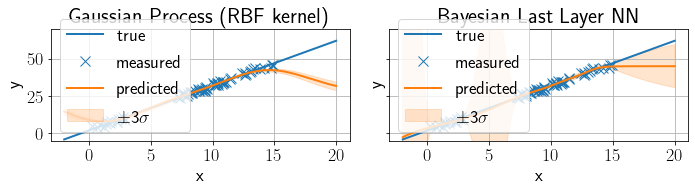

In [29]:
n_sig = 3

fig, ax = plt.subplots(1,2, sharex=True, sharey = True, figsize=(10,3))

# GP
figure_1d_data(ax[0], true=true, train=train, test=(x_test,y_hat_gp))
ax[0].fill_between(x_test.flatten(), y_hat_gp-n_sig*std_gp, y_hat_gp+n_sig*std_gp, alpha=0.2, label=f'$\pm${n_sig}$\sigma$', color=color[1])
ax[0].legend()


# NN
figure_1d_data(ax[1], true=true, train=train, test=(x_test,y_hat_nn))
ax[1].fill_between(x_test.flatten(), y_hat_nn-n_sig*std_nn, y_hat_nn+n_sig*std_nn, alpha=0.2, label=f'$\pm${n_sig}$\sigma$', color=color[1])
ax[1].legend()

#ax[1].set_xlim(-1,3)
ax[1].set_ylim(-5,70)

ax[0].set_title('Gaussian Process (RBF kernel)')
ax[1].set_title('Bayesian Last Layer NN')

fig.tight_layout()

## 2D example

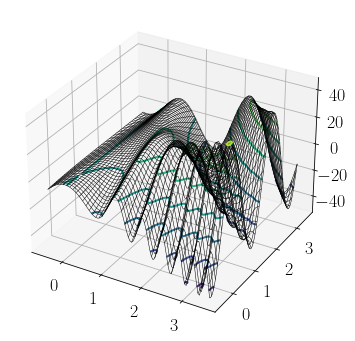

In [6]:
x = np.linspace(-0.5,3.5, 100)
X1, X2 = np.meshgrid(x,x)

y = (X1+3)**2*np.sin(X2*X1)- np.sin(np.pi*X1**2)*(X2-3)**2

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X1,X2,y, color='k', linewidth=0.5)
ax.contour(X1,X2,y)

X = np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis=1)
Y = y.reshape(-1,1)

true = (X,Y)

Use only some data (data from three centers is considered)

In [7]:
np.random.seed(10)

c1 = np.array([1,1]).reshape(1,-1)
c2 = np.array([2.5,2.5]).reshape(1,-1)
c3 = np.array([0, 3]).reshape(1,-1)


ind = (np.linalg.norm(X-c1, axis=1)<=.7+0.2*np.random.randn(X.shape[0]))
ind += (np.linalg.norm(X-c2, axis=1)<=.3+0.2*np.random.randn(X.shape[0]))
ind += (np.linalg.norm(X-c3, axis=1)<=.3+0.2*np.random.randn(X.shape[0]))

#ind = ind * np.random.rand(ind.size)>0.7

train = (X[ind], Y[ind])
val = (X[~ind], Y[~ind])

In [70]:
train[0].shape

(1529, 2)

Text(0, 0.5, 'y')

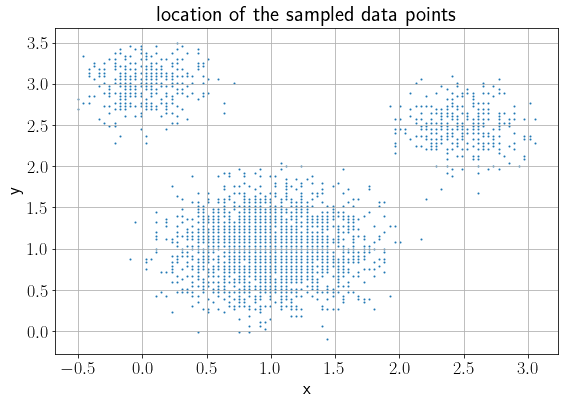

In [8]:
fig, ax = plt.subplots()
ax.scatter(train[0][:,0],train[0][:,1], marker='x', s=0.5)
#ax.scatter(val[0][:,0],val[0][:,1], marker='x', s=0.5)
ax.set_title('location of the sampled data points')
ax.set_xlabel('x')
ax.set_ylabel('y')


In [9]:
architecture = [2, 50, 50, 1]
tf.random.set_seed(123)

model, outputs = get_keras_model(architecture, 'tanh')

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.MSE,
)

activation_model = tf.keras.Model(inputs=outputs[0],outputs=outputs[-2])

2021-11-23 15:40:32.321679: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-23 15:40:32.324322: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
history = model.fit(
    train[0],
    train[1],
    epochs=3000,
    batch_size = 100
)

2021-11-23 15:40:33.187007: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/3000
16/16 [==============================] - 0s 807us/step - loss: 151.9051
Epoch 2/3000
16/16 [==============================] - 0s 646us/step - loss: 123.2040
Epoch 3/3000
16/16 [==============================] - 0s 732us/step - loss: 114.2951
Epoch 4/3000
16/16 [==============================] - 0s 729us/step - loss: 114.9339
Epoch 5/3000
16/16 [==============================] - 0s 633us/step - loss: 109.0051
Epoch 6/3000
16/16 [==============================] - 0s 594us/step - loss: 101.1918
Epoch 7/3000
16/16 [==============================] - 0s 609us/step - loss: 96.4525
Epoch 8/3000
16/16 [==============================] - 0s 607us/step - loss: 83.2676
Epoch 9/3000
16/16 [==============================] - 0s 609us/step - loss: 80.7952
Epoch 10/3000
16/16 [==============================] - 0s 639us/step - loss: 78.8788
Epoch 11/3000
16/16 [==============================] - 0s 585us/step - loss: 76.2797
Epoch 12/3000
16/16 [==============================] - 0s 614us/step

16/16 [==============================] - 0s 648us/step - loss: 1.2342
Epoch 194/3000
16/16 [==============================] - 0s 588us/step - loss: 1.2841
Epoch 195/3000
16/16 [==============================] - 0s 576us/step - loss: 1.7982
Epoch 196/3000
16/16 [==============================] - 0s 599us/step - loss: 1.2701
Epoch 197/3000
16/16 [==============================] - 0s 630us/step - loss: 1.3081
Epoch 198/3000
16/16 [==============================] - 0s 625us/step - loss: 1.3107
Epoch 199/3000
16/16 [==============================] - 0s 584us/step - loss: 1.0140
Epoch 200/3000
16/16 [==============================] - 0s 602us/step - loss: 1.1959
Epoch 201/3000
16/16 [==============================] - 0s 597us/step - loss: 1.0570
Epoch 202/3000
16/16 [==============================] - 0s 594us/step - loss: 1.1746
Epoch 203/3000
16/16 [==============================] - 0s 597us/step - loss: 1.0322
Epoch 204/3000
16/16 [==============================] - 0s 593us/step - loss: 1.

16/16 [==============================] - 0s 634us/step - loss: 0.2689
Epoch 386/3000
16/16 [==============================] - 0s 583us/step - loss: 0.3155
Epoch 387/3000
16/16 [==============================] - 0s 592us/step - loss: 0.3321
Epoch 388/3000
16/16 [==============================] - 0s 588us/step - loss: 0.2758
Epoch 389/3000
16/16 [==============================] - 0s 609us/step - loss: 0.2940
Epoch 390/3000
16/16 [==============================] - 0s 623us/step - loss: 0.3024
Epoch 391/3000
16/16 [==============================] - 0s 586us/step - loss: 0.3294
Epoch 392/3000
16/16 [==============================] - 0s 596us/step - loss: 0.2194
Epoch 393/3000
16/16 [==============================] - 0s 593us/step - loss: 0.3166
Epoch 394/3000
16/16 [==============================] - 0s 592us/step - loss: 0.2150
Epoch 395/3000
16/16 [==============================] - 0s 615us/step - loss: 0.2334
Epoch 396/3000
16/16 [==============================] - 0s 593us/step - loss: 0.

16/16 [==============================] - 0s 590us/step - loss: 0.2282
Epoch 578/3000
16/16 [==============================] - 0s 609us/step - loss: 0.1758
Epoch 579/3000
16/16 [==============================] - 0s 580us/step - loss: 0.2308
Epoch 580/3000
16/16 [==============================] - 0s 616us/step - loss: 0.2628
Epoch 581/3000
16/16 [==============================] - 0s 610us/step - loss: 0.3836
Epoch 582/3000
16/16 [==============================] - 0s 605us/step - loss: 0.2022
Epoch 583/3000
16/16 [==============================] - 0s 587us/step - loss: 0.1987
Epoch 584/3000
16/16 [==============================] - 0s 590us/step - loss: 0.3066
Epoch 585/3000
16/16 [==============================] - 0s 577us/step - loss: 0.8805
Epoch 586/3000
16/16 [==============================] - 0s 597us/step - loss: 1.7035
Epoch 587/3000
16/16 [==============================] - 0s 676us/step - loss: 1.9323
Epoch 588/3000
16/16 [==============================] - 0s 591us/step - loss: 0.

16/16 [==============================] - 0s 581us/step - loss: 0.2495
Epoch 770/3000
16/16 [==============================] - 0s 584us/step - loss: 0.1699
Epoch 771/3000
16/16 [==============================] - 0s 597us/step - loss: 0.4654
Epoch 772/3000
16/16 [==============================] - 0s 612us/step - loss: 0.3232
Epoch 773/3000
16/16 [==============================] - 0s 600us/step - loss: 0.2126
Epoch 774/3000
16/16 [==============================] - 0s 575us/step - loss: 0.1511
Epoch 775/3000
16/16 [==============================] - 0s 594us/step - loss: 0.1702
Epoch 776/3000
16/16 [==============================] - 0s 599us/step - loss: 0.2183
Epoch 777/3000
16/16 [==============================] - 0s 609us/step - loss: 0.2039
Epoch 778/3000
16/16 [==============================] - 0s 615us/step - loss: 0.1114
Epoch 779/3000
16/16 [==============================] - 0s 593us/step - loss: 0.1383
Epoch 780/3000
16/16 [==============================] - 0s 604us/step - loss: 0.

16/16 [==============================] - 0s 595us/step - loss: 0.4047
Epoch 962/3000
16/16 [==============================] - 0s 601us/step - loss: 0.4860
Epoch 963/3000
16/16 [==============================] - 0s 625us/step - loss: 0.2032
Epoch 964/3000
16/16 [==============================] - 0s 630us/step - loss: 0.1691
Epoch 965/3000
16/16 [==============================] - 0s 606us/step - loss: 0.1894
Epoch 966/3000
16/16 [==============================] - 0s 592us/step - loss: 0.2649
Epoch 967/3000
16/16 [==============================] - 0s 602us/step - loss: 0.4311
Epoch 968/3000
16/16 [==============================] - 0s 617us/step - loss: 0.3889
Epoch 969/3000
16/16 [==============================] - 0s 589us/step - loss: 0.2360
Epoch 970/3000
16/16 [==============================] - 0s 606us/step - loss: 0.6325
Epoch 971/3000
16/16 [==============================] - 0s 617us/step - loss: 0.2729
Epoch 972/3000
16/16 [==============================] - 0s 585us/step - loss: 0.

16/16 [==============================] - 0s 602us/step - loss: 0.1785
Epoch 1152/3000
16/16 [==============================] - 0s 570us/step - loss: 0.2052
Epoch 1153/3000
16/16 [==============================] - 0s 604us/step - loss: 0.1804
Epoch 1154/3000
16/16 [==============================] - 0s 591us/step - loss: 0.2356
Epoch 1155/3000
16/16 [==============================] - 0s 592us/step - loss: 0.2224
Epoch 1156/3000
16/16 [==============================] - 0s 610us/step - loss: 0.1492
Epoch 1157/3000
16/16 [==============================] - 0s 610us/step - loss: 0.1582
Epoch 1158/3000
16/16 [==============================] - 0s 597us/step - loss: 0.2649
Epoch 1159/3000
16/16 [==============================] - 0s 597us/step - loss: 0.2136
Epoch 1160/3000
16/16 [==============================] - 0s 607us/step - loss: 0.2711
Epoch 1161/3000
16/16 [==============================] - 0s 604us/step - loss: 0.2503
Epoch 1162/3000
16/16 [==============================] - 0s 592us/step

16/16 [==============================] - 0s 611us/step - loss: 0.3600
Epoch 1342/3000
16/16 [==============================] - 0s 620us/step - loss: 0.4359
Epoch 1343/3000
16/16 [==============================] - 0s 656us/step - loss: 0.2670
Epoch 1344/3000
16/16 [==============================] - 0s 626us/step - loss: 0.2279
Epoch 1345/3000
16/16 [==============================] - 0s 672us/step - loss: 0.2048
Epoch 1346/3000
16/16 [==============================] - 0s 641us/step - loss: 0.3503
Epoch 1347/3000
16/16 [==============================] - 0s 596us/step - loss: 0.1660
Epoch 1348/3000
16/16 [==============================] - 0s 604us/step - loss: 0.7104
Epoch 1349/3000
16/16 [==============================] - 0s 634us/step - loss: 3.0208
Epoch 1350/3000
16/16 [==============================] - 0s 624us/step - loss: 1.3219
Epoch 1351/3000
16/16 [==============================] - 0s 651us/step - loss: 0.8767
Epoch 1352/3000
16/16 [==============================] - 0s 591us/step

16/16 [==============================] - 0s 592us/step - loss: 0.3831
Epoch 1532/3000
16/16 [==============================] - 0s 580us/step - loss: 0.1273
Epoch 1533/3000
16/16 [==============================] - 0s 611us/step - loss: 0.1623
Epoch 1534/3000
16/16 [==============================] - 0s 579us/step - loss: 0.1671
Epoch 1535/3000
16/16 [==============================] - 0s 599us/step - loss: 0.0858
Epoch 1536/3000
16/16 [==============================] - 0s 620us/step - loss: 0.1374
Epoch 1537/3000
16/16 [==============================] - 0s 629us/step - loss: 0.1904
Epoch 1538/3000
16/16 [==============================] - 0s 602us/step - loss: 0.2289
Epoch 1539/3000
16/16 [==============================] - 0s 597us/step - loss: 0.2670
Epoch 1540/3000
16/16 [==============================] - 0s 594us/step - loss: 0.4542
Epoch 1541/3000
16/16 [==============================] - 0s 594us/step - loss: 1.0532
Epoch 1542/3000
16/16 [==============================] - 0s 606us/step

16/16 [==============================] - 0s 642us/step - loss: 0.2723
Epoch 1722/3000
16/16 [==============================] - 0s 604us/step - loss: 0.1872
Epoch 1723/3000
16/16 [==============================] - 0s 593us/step - loss: 0.2140
Epoch 1724/3000
16/16 [==============================] - 0s 599us/step - loss: 0.3252
Epoch 1725/3000
16/16 [==============================] - 0s 585us/step - loss: 0.5550
Epoch 1726/3000
16/16 [==============================] - 0s 615us/step - loss: 0.4187
Epoch 1727/3000
16/16 [==============================] - 0s 596us/step - loss: 0.1979
Epoch 1728/3000
16/16 [==============================] - 0s 646us/step - loss: 0.1545
Epoch 1729/3000
16/16 [==============================] - 0s 593us/step - loss: 0.2389
Epoch 1730/3000
16/16 [==============================] - 0s 612us/step - loss: 0.1566
Epoch 1731/3000
16/16 [==============================] - 0s 602us/step - loss: 0.1556
Epoch 1732/3000
16/16 [==============================] - 0s 608us/step

16/16 [==============================] - 0s 632us/step - loss: 0.2470
Epoch 1912/3000
16/16 [==============================] - 0s 592us/step - loss: 0.1663
Epoch 1913/3000
16/16 [==============================] - 0s 609us/step - loss: 0.1311
Epoch 1914/3000
16/16 [==============================] - 0s 605us/step - loss: 0.2867
Epoch 1915/3000
16/16 [==============================] - 0s 614us/step - loss: 0.1842
Epoch 1916/3000
16/16 [==============================] - 0s 617us/step - loss: 0.2073
Epoch 1917/3000
16/16 [==============================] - 0s 599us/step - loss: 0.1992
Epoch 1918/3000
16/16 [==============================] - 0s 612us/step - loss: 0.1517
Epoch 1919/3000
16/16 [==============================] - 0s 614us/step - loss: 0.1356
Epoch 1920/3000
16/16 [==============================] - 0s 609us/step - loss: 0.0948
Epoch 1921/3000
16/16 [==============================] - 0s 582us/step - loss: 0.1062
Epoch 1922/3000
16/16 [==============================] - 0s 604us/step

16/16 [==============================] - 0s 613us/step - loss: 0.2282
Epoch 2102/3000
16/16 [==============================] - 0s 590us/step - loss: 0.3903
Epoch 2103/3000
16/16 [==============================] - 0s 621us/step - loss: 0.1982
Epoch 2104/3000
16/16 [==============================] - 0s 650us/step - loss: 0.2983
Epoch 2105/3000
16/16 [==============================] - 0s 615us/step - loss: 0.1374
Epoch 2106/3000
16/16 [==============================] - 0s 597us/step - loss: 0.1562
Epoch 2107/3000
16/16 [==============================] - 0s 599us/step - loss: 0.2602
Epoch 2108/3000
16/16 [==============================] - 0s 620us/step - loss: 0.6605
Epoch 2109/3000
16/16 [==============================] - 0s 608us/step - loss: 0.8433
Epoch 2110/3000
16/16 [==============================] - 0s 592us/step - loss: 1.2420
Epoch 2111/3000
16/16 [==============================] - 0s 605us/step - loss: 1.5059
Epoch 2112/3000
16/16 [==============================] - 0s 583us/step

16/16 [==============================] - 0s 633us/step - loss: 0.2348
Epoch 2292/3000
16/16 [==============================] - 0s 588us/step - loss: 0.2606
Epoch 2293/3000
16/16 [==============================] - 0s 602us/step - loss: 0.1563
Epoch 2294/3000
16/16 [==============================] - 0s 599us/step - loss: 0.1759
Epoch 2295/3000
16/16 [==============================] - 0s 583us/step - loss: 0.1489
Epoch 2296/3000
16/16 [==============================] - 0s 603us/step - loss: 0.3717
Epoch 2297/3000
16/16 [==============================] - 0s 588us/step - loss: 2.4620
Epoch 2298/3000
16/16 [==============================] - 0s 636us/step - loss: 3.7590
Epoch 2299/3000
16/16 [==============================] - 0s 615us/step - loss: 1.3088
Epoch 2300/3000
16/16 [==============================] - 0s 595us/step - loss: 0.2978
Epoch 2301/3000
16/16 [==============================] - 0s 619us/step - loss: 0.1710
Epoch 2302/3000
16/16 [==============================] - 0s 600us/step

16/16 [==============================] - 0s 573us/step - loss: 0.5302
Epoch 2482/3000
16/16 [==============================] - 0s 605us/step - loss: 0.4881
Epoch 2483/3000
16/16 [==============================] - 0s 639us/step - loss: 0.2860
Epoch 2484/3000
16/16 [==============================] - 0s 602us/step - loss: 0.1613
Epoch 2485/3000
16/16 [==============================] - 0s 602us/step - loss: 0.1723
Epoch 2486/3000
16/16 [==============================] - 0s 644us/step - loss: 0.2210
Epoch 2487/3000
16/16 [==============================] - 0s 612us/step - loss: 0.1589
Epoch 2488/3000
16/16 [==============================] - 0s 590us/step - loss: 0.1174
Epoch 2489/3000
16/16 [==============================] - 0s 597us/step - loss: 0.1794
Epoch 2490/3000
16/16 [==============================] - 0s 607us/step - loss: 0.1315
Epoch 2491/3000
16/16 [==============================] - 0s 591us/step - loss: 0.2198
Epoch 2492/3000
16/16 [==============================] - 0s 622us/step

16/16 [==============================] - 0s 606us/step - loss: 0.1543
Epoch 2672/3000
16/16 [==============================] - 0s 599us/step - loss: 0.1030
Epoch 2673/3000
16/16 [==============================] - 0s 596us/step - loss: 0.0957
Epoch 2674/3000
16/16 [==============================] - 0s 614us/step - loss: 0.1009
Epoch 2675/3000
16/16 [==============================] - 0s 619us/step - loss: 0.1345
Epoch 2676/3000
16/16 [==============================] - 0s 602us/step - loss: 0.1016
Epoch 2677/3000
16/16 [==============================] - 0s 607us/step - loss: 0.1435
Epoch 2678/3000
16/16 [==============================] - 0s 622us/step - loss: 0.1743
Epoch 2679/3000
16/16 [==============================] - 0s 618us/step - loss: 0.1894
Epoch 2680/3000
16/16 [==============================] - 0s 627us/step - loss: 0.1311
Epoch 2681/3000
16/16 [==============================] - 0s 642us/step - loss: 0.1074
Epoch 2682/3000
16/16 [==============================] - 0s 631us/step

16/16 [==============================] - 0s 588us/step - loss: 0.5194
Epoch 2862/3000
16/16 [==============================] - 0s 627us/step - loss: 0.2725
Epoch 2863/3000
16/16 [==============================] - 0s 637us/step - loss: 0.1554
Epoch 2864/3000
16/16 [==============================] - 0s 604us/step - loss: 0.1546
Epoch 2865/3000
16/16 [==============================] - 0s 657us/step - loss: 0.1349
Epoch 2866/3000
16/16 [==============================] - 0s 594us/step - loss: 0.3265
Epoch 2867/3000
16/16 [==============================] - 0s 602us/step - loss: 0.4283
Epoch 2868/3000
16/16 [==============================] - 0s 592us/step - loss: 0.3210
Epoch 2869/3000
16/16 [==============================] - 0s 583us/step - loss: 0.1548
Epoch 2870/3000
16/16 [==============================] - 0s 604us/step - loss: 0.1527
Epoch 2871/3000
16/16 [==============================] - 0s 606us/step - loss: 0.1454
Epoch 2872/3000
16/16 [==============================] - 0s 589us/step

In [11]:
sig_w = 1e0
sig_e = 1e0

Sigma_E = np.eye(train[1].shape[0])*1/sig_e**2          
Sigma_W = np.eye(architecture[-2])*1/sig_w**2

x_test = true[0]
y_test = true[1]
y_hat_nn = model.predict(x_test)
a_train = activation_model.predict(train[0])
a_hat = activation_model.predict(x_test)

cov = a_hat@np.linalg.inv(a_train.T@Sigma_E@a_train+Sigma_W)@a_hat.T
std2_nn_raw = np.diag(cov).reshape(X1.shape)
std_nn_raw = np.sqrt(std2_nn_raw)
err_nn_raw = np.abs(y_hat_nn-y_test).reshape(X1.shape)

std2_nn = copy.copy(std2_nn_raw)
std_nn = copy.copy(std_nn_raw)
err_nn = copy.copy(err_nn_raw)

cutoff = 80
std_nn[std_nn>np.percentile(std_nn,cutoff)] = np.percentile(std_nn,cutoff)
std2_nn[std2_nn>np.percentile(std2_nn,cutoff)] = np.percentile(std2_nn,cutoff)
err_nn[err_nn>np.percentile(err_nn,cutoff)] = np.percentile(err_nn,cutoff)

std2_nn_norm = std2_nn/std2_nn.max()
std_nn_norm = std_nn/std_nn.max()
err_nn_norm = err_nn/err_nn.max()

cm_std2_nn = cm.jet(std2_nn_norm)
cm_std_nn = cm.jet(std_nn_norm)
cm_err_nn = cm.jet(err_nn_norm)

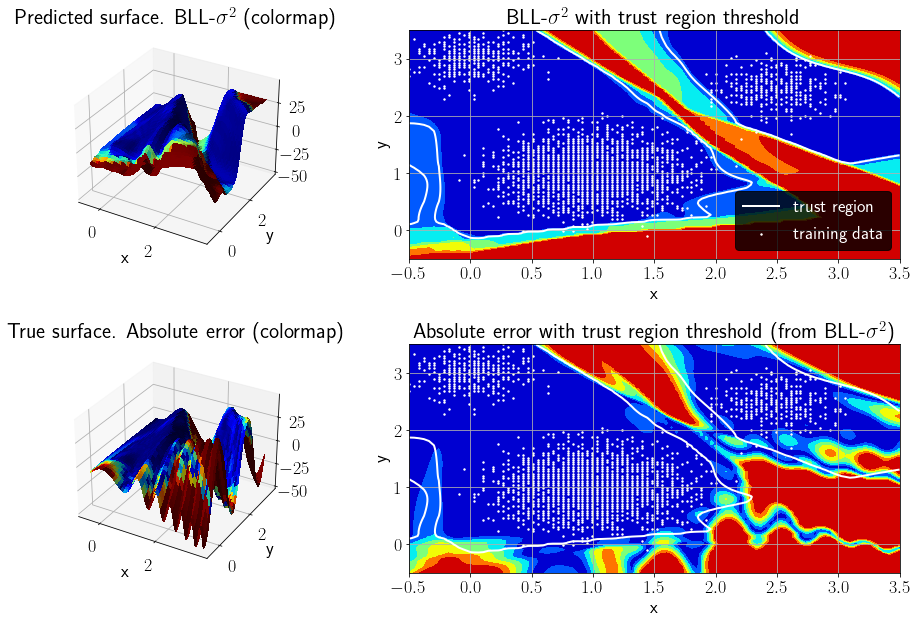

In [12]:
trust_threshold = 0.2

fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.set_title('Predicted surface. BLL-$\sigma^2$ (colormap)')
ax.plot_surface(X1,X2,y_hat_nn.reshape(X1.shape), facecolors=cm_std2_nn, linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(2, 2, 3, projection='3d', sharez=ax, sharex=ax, sharey=ax)
ax.plot_surface(X1,X2,y.reshape(X1.shape), facecolors=cm_err_nn, linewidth=0, antialiased=False)
ax.set_title('True surface. Absolute error (colormap)')
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(2, 2, 2)
ax.contourf(X1,X2,std2_nn_norm, cmap='jet')
ax.contour(X1,X2,std2_nn_norm,[trust_threshold], colors='w')
ax.plot([],[], color='w', label='trust region')
ax.scatter(train[0][:,0],train[0][:,1], s=2,color='w', marker='o', alpha=1, label='training data')
leg = ax.legend()
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_facecolor('k')
plt.setp(leg.get_texts(), color='w')

ax.set_title('BLL-$\sigma^2$ with trust region threshold')
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(2, 2, 4, sharex=ax, sharey=ax)
ax.contourf(X1,X2,err_nn_norm, cmap='jet')
ax.contour(X1,X2,std2_nn_norm,[trust_threshold], colors='w')
ax.scatter(train[0][:,0],train[0][:,1], s=2,color='w', marker='o', alpha=1)
ax.set_title('Absolute error with trust region threshold (from BLL-$\sigma^2$)')
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.tight_layout()

In [13]:
trust_region_ind = (std2_nn_norm<trust_threshold).reshape(-1,1)

tot_err_nn_tr = np.mean(err_nn_raw.reshape(-1,1)[trust_region_ind])
tot_err_nn_full = np.mean(err_nn_raw)
tot_trust_region_nn = np.sum(trust_region_ind)/std_nn_norm.size

print(f'Total trust region size:{tot_trust_region_nn} with a mean error of {tot_err_nn_tr}')
print(f'Mean error of entire space:{tot_err_nn_full}')

Total trust region size:0.5879 with a mean error of 0.8625736511547053
Mean error of entire space:7.405122205215588


In [14]:
sig_w_gp = 1e0

gpr = GaussianProcessRegressor(kernel=RBF(),normalize_y=True, alpha=1/(sig_w_gp**2)).fit(*train)

y_hat_gp, std_gp_raw = gpr.predict(true[0], return_std=True)

In [16]:
err_gp_raw = np.abs(y_hat_gp-y_test).reshape(X1.shape)
std_gp_raw = std_gp_raw.reshape(X1.shape)
std2_gp_raw = std_gp_raw**2

std2_gp = copy.copy(std2_gp_raw)
std_gp = copy.copy(std_gp_raw)
err_gp = copy.copy(err_gp_raw)

cutoff = 80
std2_gp[std2_gp>np.percentile(std2_gp,cutoff)] = np.percentile(std2_gp,cutoff)
std_gp[std_gp>np.percentile(std_gp,cutoff)] = np.percentile(std_gp,cutoff)
err_gp[err_gp>np.percentile(err_gp,cutoff)] = np.percentile(err_gp,cutoff)

std2_gp_norm = std2_gp/std2_gp.max()
std_gp_norm = std_gp/std_gp.max()
# Normalize with same value as for NN
err_gp_norm = err_gp/err_nn.max()

cm_std2_gp = cm.jet(std2_gp_norm)
cm_std_gp = cm.jet(std_gp_norm)
cm_err_gp = cm.jet(err_gp_norm)

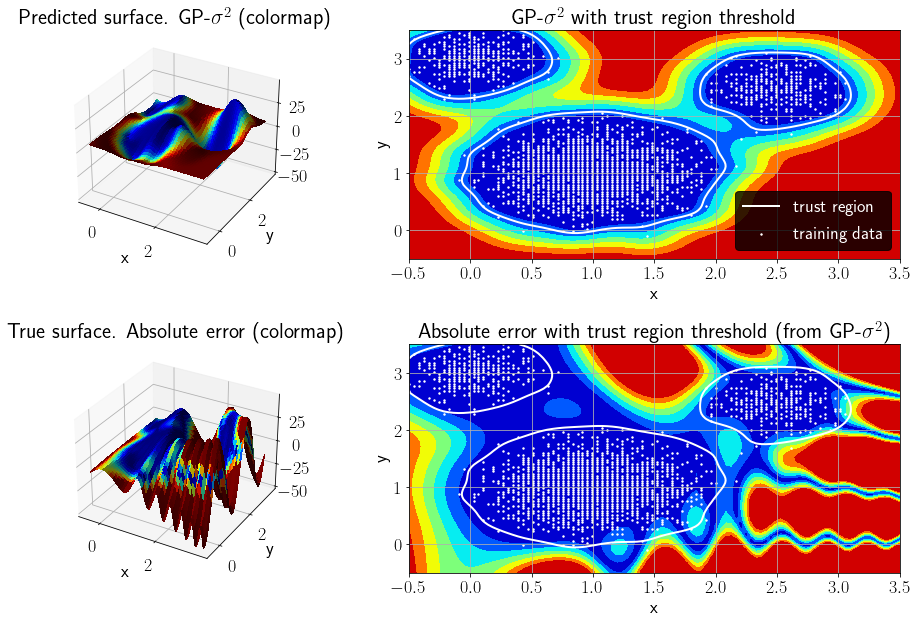

In [17]:
trust_threshold = 0.2

fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.set_title('Predicted surface. GP-$\sigma^2$ (colormap)')
ax.plot_surface(X1,X2,y_hat_gp.reshape(X1.shape), facecolors=cm_std2_gp,linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(2, 2, 3, projection='3d', sharez=ax, sharex=ax, sharey=ax)
ax.plot_surface(X1,X2,y.reshape(X1.shape), facecolors=cm_err_gp, linewidth=0, antialiased=False)
ax.set_title('True surface. Absolute error (colormap)')
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(2, 2, 2)
ax.contourf(X1,X2,std2_gp_norm, cmap='jet')
ax.contour(X1,X2,std2_gp_norm,[trust_threshold], colors='w')
ax.plot([],[], color='w', label='trust region')
ax.scatter(train[0][:,0],train[0][:,1], s=2,color='w', marker='o', alpha=1, label='training data')
leg = ax.legend()
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_facecolor('k')
plt.setp(leg.get_texts(), color='w')

ax.set_title('GP-$\sigma^2$ with trust region threshold')
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(2, 2, 4, sharex=ax, sharey=ax)
ax.contourf(X1,X2,err_gp_norm, cmap='jet')
ax.contour(X1,X2,std2_gp_norm,[trust_threshold], colors='w')
ax.scatter(train[0][:,0],train[0][:,1], s=2,color='w', marker='o', alpha=1)
ax.set_title('Absolute error with trust region threshold (from GP-$\sigma^2$)')
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.tight_layout()

## Combined plot for publication

In [52]:
f'${cov_str}^{gp_str}$'

'$\\mathbf{\\Sigma}_{\\hat \\mathbf{y}}^\text{\\scriptscriptsize NN}$'

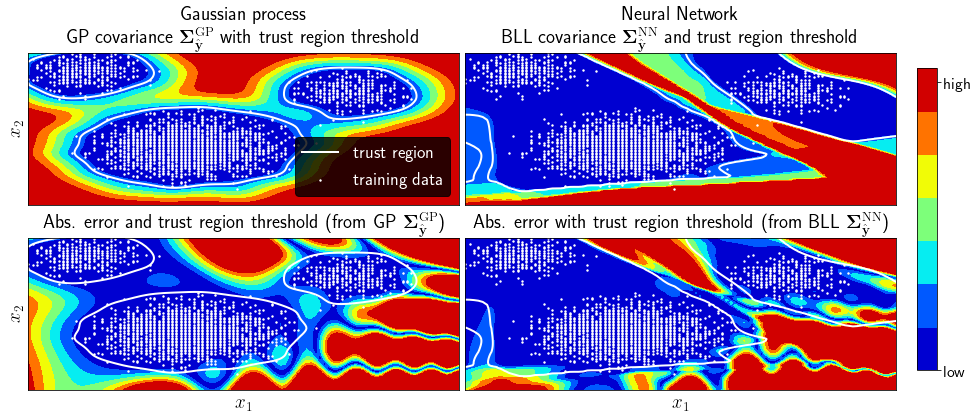

In [69]:
mpl.rcParams.update({
    'font.size': 16,
    'axes.labelsize': 'Large',
})

trust_threshold = 0.2

fig, ax = plt.subplots(2,2, figsize=(14,6), sharex=True, sharey=True)

cov_str = '\mathbf{\Sigma}_{\hat \mathbf{y}}'
nn_str = '{\mathrm{\scriptsize NN}}'
gp_str = '{\mathrm{\scriptsize GP}}'

ax[0,0].contourf(X1,X2,std2_gp_norm, cmap='jet')
ax[0,0].contour(X1,X2,std2_gp_norm,[trust_threshold], colors='w')
ax[0,0].plot([],[], color='w', label='trust region')
ax[0,0].scatter(train[0][:,0],train[0][:,1], s=2,color='w', marker='o', alpha=1, label='training data')
leg = ax[0,0].legend(fontsize=18)
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_facecolor('k')
plt.setp(leg.get_texts(), color='w')

ax[0,0].set_title(f'Gaussian process \n GP covariance ${cov_str}^{gp_str}$ with trust region threshold', pad=10)
ax[0,0].set_ylabel('$x_2$')

ax[1,0].contourf(X1,X2,err_gp_norm, cmap='jet')
ax[1,0].contour(X1,X2,std2_gp_norm,[trust_threshold], colors='w')
ax[1,0].scatter(train[0][:,0],train[0][:,1], s=2,color='w', marker='o', alpha=1)
ax[1,0].set_title(f'Abs. error and trust region threshold (from GP ${cov_str}^{gp_str}$)', pad=10)
ax[1,0].set_xlabel('$x_1$')
ax[1,0].set_ylabel('$x_2$')


ax[0,1].contourf(X1,X2,std2_nn_norm, cmap='jet')
ax[0,1].contour(X1,X2,std2_nn_norm,[trust_threshold], colors='w')
ax[0,1].plot([],[], color='w', label='trust region')
ax[0,1].scatter(train[0][:,0],train[0][:,1], s=2,color='w', marker='o', alpha=1, label='training data')

ax[0,1].set_title(f'Neural Network \n BLL covariance ${cov_str}^{nn_str}$ and trust region threshold', pad = 10)

cim = ax[1,1].contourf(X1,X2,err_nn_norm, cmap='jet')
ax[1,1].contour(X1,X2,std2_nn_norm,[trust_threshold], colors='w')
ax[1,1].scatter(train[0][:,0],train[0][:,1], s=2,color='w', marker='o', alpha=1)
ax[1,1].set_title(f'Abs. error with trust region threshold (from BLL ${cov_str}^{nn_str}$)', pad=10)
ax[1,1].set_xlabel('$x_1$')

fig.tight_layout(pad=0.2)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(cim, cax=cbar_ax, ticks=[np.max(err_nn_norm), np.min(err_nn_norm)])
cbar.ax.set_yticklabels(['high', 'low'])  # vertically oriented colorbar

ax[0,0].xaxis.set_ticks([])
ax[0,0].yaxis.set_ticks([])

fig.savefig('./figures/BLL_GP_2D_trust_region.pdf',format='pdf',pad_inches=0)

## Some metrics to compare both cases in 2D

In [211]:
trust_region_ind_gp = (std2_gp_norm<trust_threshold).reshape(-1,1)

tot_err_gp_tr = np.mean(err_gp_raw.reshape(-1,1)[trust_region_ind_gp])
tot_err_gp_full = np.mean(err_gp_raw)
tot_trust_region_gp = np.sum(trust_region_ind_gp)/std_gp_norm.size

print('Gaussian process:')
print(f'Total trust region size: {100*tot_trust_region_gp:.2f}% with a mean error of {tot_err_gp_tr:.2f}')
print(f'Mean error of entire space:{tot_err_gp_full:.2f}')

Gaussian process:
Total trust region size: 36.45% with a mean error of 0.76
Mean error of entire space:8.10


In [212]:
trust_region_ind = (std2_nn_norm<trust_threshold).reshape(-1,1)

tot_err_nn_tr = np.mean(err_nn_raw.reshape(-1,1)[trust_region_ind])
tot_err_nn_full = np.mean(err_nn_raw)
tot_trust_region_nn = np.sum(trust_region_ind)/std_nn_norm.size

print('Neural Network:')
print(f'Total trust region size: {100*tot_trust_region_nn:.2f}% with a mean error of {tot_err_nn_tr:.2f}')
print(f'Mean error of entire space:{tot_err_nn_full:.2f}')

Neural Network:
Total trust region size: 58.79% with a mean error of 0.86
Mean error of entire space:7.41


What if we just the convex hull as a trust region?

In [170]:
hull = scipy.spatial.ConvexHull(train[0])

In [176]:
A_ch, b_ch = np.split(hull.equations,[2],axis=1)
ind_cv = (np.max(A_ch@true[0].T+b_ch,axis=0)<0)

Text(0, 0.5, 'y')

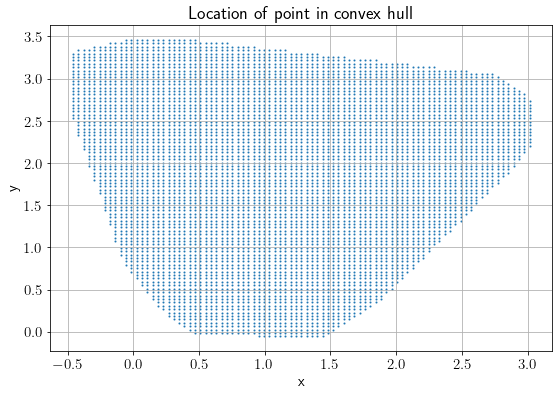

In [191]:
fig, ax = plt.subplots()
ax.scatter(true[0][ind_cv,0],true[0][ind_cv,1], marker='x', s=0.5)
ax.set_title('Location of point in convex hull')
ax.set_xlabel('x')
ax.set_ylabel('y')

In [209]:
tot_err_gp_cv = np.mean(err_gp_raw.reshape(-1,1)[ind_cv])
tot_err_nn_cv = np.mean(err_nn_raw.reshape(-1,1)[ind_cv])

print(f'Mean error of GP in convex hull of data points: {tot_err_gp_cv:.2f}')
print(f'Mean error of NN in convex hull of data points: {tot_err_nn_cv:.2f}')

Mean error of GP in convex hull of data points: 2.51
Mean error of NN in convex hull of data points: 1.54
